In [ ]:
!git clone https://github.com/crashmoon/Progressive-Generative-Networks.git

fatal: destination path 'Progressive-Generative-Networks' already exists and is not an empty directory.


In [ ]:
!pip install plot
!pip install pynvml
!pip install pytorch_ssim



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import MNIST
from torchvision.datasets import CelebA
import pynvml
import pytorch_ssim
from skimage.metrics import structural_similarity as ssim


In [ ]:

pynvml.nvmlInit()

# Get handle for GPU 0
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

# Get power usage
power_usage = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000.0  # convert to watts

# Get GPU utilization
utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
gpu_utilization = utilization.gpu

# Get fan speed
#fan_speed = pynvml.nvmlDeviceGetFanSpeed(handle)

# Get temperature
temperature = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)

In [ ]:
dataset = CelebA('/content', download=True)

Files already downloaded and verified


In [ ]:
import sys
import numpy as np
from skimage import io, transform
import csv
import cv2
import os

os.chdir('/content/celeba/img_align_celeba/')
name = os.listdir(os.getcwd())
print(len(name))
# with open('/content/Progressive-Generative-Networks/gan_lstm.csv','w') as csvfile:    
#     w = csv.writer(csvfile)
#     w.writerow([0, 1])

id = 0
with open('/content/Progressive-Generative-Networks/gan_lstm.csv','w') as csvfile:    
    w = csv.writer(csvfile)
    w.writerow([0, 1])
    for x in name:
        w.writerow(['/content/celeba/img_align_celeba/'+x, id])
        id+=1
    
    
cv2.destroyAllWindows()


202599


In [ ]:
pip install plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function, division
import torch.nn as nn
import numpy as np

import plot

import scipy.misc
# from scipy.misc import imsave // deprecated
import imageio

import torch
from torch.autograd import Variable
import torch.autograd as autograd

from os.path import join
from glob import glob
from torch.utils.data import Dataset, DataLoader

import os
from skimage import io, transform
from skimage.transform import resize
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import time
import random
import cv2


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

class Param:
    unet_channel = 64
    cnn_channel = 64
    batch_size = 16
    image_size = 128
    n_critic = 1
    gan_weight = 0.001
    tv_weight = 1.0
    weight_decay = 0.00
    G_learning_rate = 0.0002
    D_learning_rate = 0.00002
    out_path = '/content/output_a100/'


def conv_down(dim_in, dim_out):
    return nn.Sequential(
        nn.LeakyReLU(0.2),
        nn.Conv2d(dim_in, dim_out, kernel_size=4, stride=2, padding=1,bias = False),
        nn.BatchNorm2d(dim_out)
    )


def conv_up(dim_in, dim_out):
    return nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(dim_in, dim_out, 4, 2, 1, bias=False),
        nn.BatchNorm2d(dim_out)
    )


class Unet(nn.Module):
    def __init__(self, unet_input_channel=3, hidden_channel=Param.unet_channel * 8):
        super(Unet, self).__init__()
        self.start = nn.Conv2d(unet_input_channel, Param.unet_channel,3,1,1)  # 128
        self.conv0 = conv_down(Param.unet_channel, Param.unet_channel)  # 64
        self.conv1 = conv_down(Param.unet_channel, Param.unet_channel * 2)  # 32
        self.conv2 = conv_down(Param.unet_channel * 2, Param.unet_channel * 4)  # 16
        self.conv3 = conv_down(Param.unet_channel * 4, Param.unet_channel * 8)  # 8
        self.conv4 = conv_down(Param.unet_channel * 8, Param.unet_channel * 8)  # 4
        self.conv5 = conv_down(Param.unet_channel * 8, Param.unet_channel * 8)  # 2
        self.conv6 = conv_down(Param.unet_channel * 8, Param.unet_channel * 8)  # 1

        self.up5 = conv_up(hidden_channel, Param.unet_channel * 8)  # 2
        self.dp5 = nn.Dropout(p=0.5)
        self.up4 = conv_up(Param.unet_channel * 8 * 2, Param.unet_channel * 8)  # 4
        self.dp4 = nn.Dropout(p=0.5)
        self.up3 = conv_up(Param.unet_channel * 8 * 2, Param.unet_channel * 8)  # 8
        self.dp3 = nn.Dropout(p=0.5)
        self.up2 = conv_up(Param.unet_channel * 8 * 2, Param.unet_channel * 4)  # 16
        self.up1 = conv_up(Param.unet_channel * 4 * 2, Param.unet_channel * 2)  # 32
        self.up0 = conv_up(Param.unet_channel * 2 * 2, Param.unet_channel)  # 64
        self.end = conv_up(Param.unet_channel * 2, 3)  # 128

        ## weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                nn.init.kaiming_normal(m.weight.data, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, data_in, hidden_input=None):
        start_out = self.start(data_in)
        conv0_out = self.conv0(start_out)
        conv1_out = self.conv1(conv0_out)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv4_out)
        conv6_out = self.conv6(conv5_out)

        mid = conv6_out  # Param.batch_size * 256 * 1 * 1

        if hidden_input is None:
            up5_out = self.up5(conv6_out)
        else:
            hidden_input = hidden_input.view(hidden_input.size(0), hidden_input.size(1), 1, 1)
            up5_out = self.up5(torch.cat((hidden_input, conv6_out), 1))

        up4_out = self.up4(torch.cat((up5_out, conv5_out), 1))
        up3_out = self.up3(torch.cat((up4_out, conv4_out), 1))
        up2_out = self.up2(torch.cat((up3_out, conv3_out), 1))
        up1_out = self.up1(torch.cat((up2_out, conv2_out), 1))
        up0_out = self.up0(torch.cat((up1_out, conv1_out), 1))
        out = self.end(torch.cat((up0_out, conv0_out), 1))
        out = F.sigmoid(out)
        return out, mid

def conv_stage(dim_in, dim_out):
    return nn.Sequential(
        nn.Conv2d(dim_in, dim_out, 4, 2, 1,bias=False),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(dim_out)
    )


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv0 = nn.Conv2d(3, Param.cnn_channel, 3, 1, 1,bias=False)
        self.conv1 = conv_stage(Param.cnn_channel, Param.cnn_channel * 2)
        self.conv2 = conv_stage(Param.cnn_channel * 2, Param.cnn_channel * 4)
        self.conv3 = nn.Conv2d(Param.cnn_channel * 4, 1, 4, 1, 1)
        self.bn0 = nn.BatchNorm2d(Param.cnn_channel)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                nn.init.kaiming_normal(m.weight.data, mode='fan_out')
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, data_in):  # map   channel
        conv0_out = self.conv0(data_in)  # 128   64
        conv0_out = self.bn0(conv0_out)
        conv1_out = self.conv1(conv0_out)  # 64    128
        conv2_out = self.conv2(conv1_out)  # 32    256
        out = self.conv3(conv2_out)  # 31    1
        out = F.sigmoid(out)
        return out

class ImageNetData(object):
    def __init__(self, csv_file, trans=None):
        self.lines = pd.read_csv(csv_file)
        self.trans = trans

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        # print(self.lines)
        image_pos = self.lines.loc[idx, 0]
        image = io.imread(image_pos)
        image = image.astype(np.float)
        h,w = image.shape[:2]
        if(h<w):
            factor = h/350.0
            w = w/factor
            h = 350
        else:
            factor = w/350.0
            h = h/factor
            w = 350
        image = transform.resize(image, (int(h), int(w), 3))
        image_id = self.lines.loc[idx, '0']
        sample = {'image': image, 'id': image_id}
        if self.trans is not None:
            sample = self.trans(sample)
        return sample

class ParisData(object):
    def __init__(self, csv_file, trans=None):
        self.lines = pd.read_csv(csv_file)
        self.trans = trans

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        # print(self.lines)
        image_pos = self.lines.loc[idx, '0']
        image = io.imread(image_pos)
        image = image.astype(np.float)
        h,w = image.shape[:2]
        if(h<w):
            factor = h/350.0
            w = w/factor
            h = 350
        else:
            factor = w/350.0
            h = h/factor
            w = 350
        image = transform.resize(image, (int(h), int(w), 3))
        image_id = self.lines.loc[idx, '1']
        sample = {'image': image, 'id': image_id}
        if self.trans is not None:
            sample = self.trans(sample)
        return sample


class RandCrop(object):
    def __call__(self, sample):
        image = sample['image']
        image_id = sample['id']
        h, w = image.shape[:2]
        sx = random.randint(0, h - Param.image_size)
        sy = random.randint(0, w - Param.image_size)
        image = image[sx:(sx + Param.image_size), sy:(sy + Param.image_size)]
        image = image.transpose((2, 0, 1))
        if(random.randint(0,1)):
            image = image[:,:,::-1]
        image /= 255.0
        image_trans = np.array(image)
        return {'image': torch.FloatTensor(image_trans), 'id': torch.Tensor([image_id])}


def inf_get(train):
    while (True):
        for x in train:
            yield x['image']

def destroy(image, crop_size=64):
    re = image.clone().cuda()
    '''
    re[:, :, int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size),
    int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size)] = torch.zeros(
        Param.batch_size, 3, crop_size, crop_size).cuda()
    '''
    re[:, 0:1, int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size),
    int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size)] = torch.zeros(
        Param.batch_size, 1, crop_size, crop_size).fill_(0.45703125).cuda()
    re[:, 1:2, int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size),
    int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size)] = torch.zeros(
        Param.batch_size, 1, crop_size, crop_size).fill_(0.40625).cuda()
    re[:, 2:3, int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size),
    int((Param.image_size - crop_size) / 2):int((Param.image_size - crop_size) / 2 + crop_size)] = torch.zeros(
        Param.batch_size, 1, crop_size, crop_size).fill_(0.48046875).cuda()

    return re


class Net_G(nn.Module):
    def __init__(self):
        super(Net_G, self).__init__()
        self.unet_1 = Unet(3, Param.unet_channel * 8)
        self.unet_2 = Unet(6, Param.unet_channel * 8 * 3)
        self.unet_3 = Unet(6, Param.unet_channel * 8 * 3)
        self.unet_4 = Unet(6, Param.unet_channel * 8 * 3)
        self.rnn = nn.LSTMCell(Param.unet_channel * 8, Param.unet_channel * 8 * 2)

    def forward(self, data_1, data_2, data_3, data_4, h0, c0):
        #print(data_1.size())
        unet_out_1, unet_mid_1 = self.unet_1(data_1)
        h1, c1 = self.rnn(unet_mid_1.view(Param.batch_size, -1), (h0, c0))
        unet_out_2, unet_mid_2 = self.unet_2(torch.cat((data_1, unet_out_1), 1), h1)
        h2, c2 = self.rnn(unet_mid_2.view(Param.batch_size, -1), (h1, c1))
        unet_out_3, unet_mid_3 = self.unet_3(torch.cat((data_1, unet_out_2), 1), h2)
        h3, c3 = self.rnn(unet_mid_3.view(Param.batch_size, -1), (h2, c2))
        unet_out_4, unet_mid_4 = self.unet_4(torch.cat((data_1, unet_out_3), 1), h3)
        return unet_out_1, unet_out_2, unet_out_3, unet_out_4


class Net_D(nn.Module):
    def __init__(self):
        super(Net_D, self).__init__()
        self.cnn1 = CNN()
        self.cnn2 = CNN()
        self.cnn3 = CNN()
        self.cnn4 = CNN()

    def forward(self, data_48, data_32, data_16, data_0):
        out1 = self.cnn1(data_48)
        out2 = self.cnn2(data_32)
        out3 = self.cnn3(data_16)
        out4 = self.cnn4(data_0)
        return out1, out2, out3, out4


def save_image_plus(x, save_path):
    x = (255.99 * x).astype('uint8')
    x = x.transpose(0, 1, 3, 4, 2)
    nh, nw = x.shape[:2]
    h = x.shape[2]
    w = x.shape[3]
    img = np.zeros((h * nh, w * nw, 3))
    for i in range(nh):
        for j in range(nw):
            img[i * h:i * h + h, j * w:j * w + w] = x[i][j]
    imageio.imwrite(save_path, img)
    # imsave(save_path, img)

def cal_tv(image):
    temp = image.clone()
    temp[:,:,:Param.image_size-1,:] = image[:,:,1:,:]
    re = ((image-temp)**2).mean()
    temp = image.clone()
    temp[:,:,:,:Param.image_size-1] = image[:,:,:,1:]
    re += ((image-temp)**2).mean()
    return re

def ssim_fn(y_true, y_pred):
    ssim_val = 0
    for i in range(y_true.shape[0]):
        true_img = y_true[i, :, :, :]
        pred_img = y_pred[i, :, :, :]
        true_img = cv2.cvtColor(true_img.permute(1,2,0).detach().cpu().numpy(), cv2.COLOR_RGB2GRAY)
        pred_img = cv2.cvtColor(pred_img.permute(1,2,0).detach().cpu().numpy(), cv2.COLOR_RGB2GRAY)
        ssim_val += ssim(true_img, pred_img, data_range=255)
    return ssim_val / y_true.shape[0]

In [ ]:
# one = torch.FloatTensor([1.0]).cuda() //deprecateed
one = torch.tensor(1.0, dtype=torch.float).cuda()
mone = torch.tensor(-1.0, dtype=torch.float).cuda()
# mone = torch.FloatTensor([-1.0]).cuda()
ones_31 = torch.zeros(Param.batch_size, 1, 31, 31).fill_(1.0).type(torch.FloatTensor).cuda()
mones_31 = torch.zeros(Param.batch_size, 1, 31, 31).fill_(-1.0).type(torch.FloatTensor).cuda()
zeros_31 = torch.zeros(Param.batch_size, 1, 31, 31).type(torch.FloatTensor).cuda()

mask = torch.ones(Param.batch_size, 3, 128, 128)
mask[:, :, 32:32 + 64, 32:32 + 64] = torch.zeros(Param.batch_size, 3, 64, 64)
mask = Variable(mask.type(torch.FloatTensor).cuda(), requires_grad=False)

h0 = torch.zeros(Param.batch_size, Param.unet_channel * 8 * 2).cuda()
c0 = torch.zeros(Param.batch_size, Param.unet_channel * 8 * 2).cuda()

netG = Net_G().cuda()
netD = Net_D().cuda()

#netG.load_state_dict(torch.load('/data/haoran/unet-gan/gan_lstm_4/netG_59999.pickle'))
#netD.load_state_dict(torch.load('/data/haoran/unet-gan/gan_lstm_4/netD_59999.pickle'))
#netG = nn.DataParallel(netG, device_ids=[0, 1])
#netD = nn.DataParallel(netD, device_ids=[0, 1])

opt_G = optim.Adam(netG.parameters(), lr=Param.G_learning_rate, betas = (0.5,0.999), weight_decay=Param.weight_decay)
opt_D = optim.Adam(netD.parameters(), lr=Param.D_learning_rate, betas = (0.5,0.999), weight_decay=Param.weight_decay)

#trainset = ParisData('paris.csv', RandCrop())
trainset = ParisData('/content/Progressive-Generative-Networks/gan_lstm.csv', RandCrop())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=Param.batch_size, shuffle=True, num_workers=2,
                                            drop_last=True)
train_data = inf_get(train_loader)



<ipython-input-8-f4580ccfeb89>:90: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_out')
<ipython-input-8-f4580ccfeb89>:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_out')


In [ ]:
epoch_start = 0
maxepoch = 10
bce_loss = nn.BCELoss()

In [ ]:
import tqdm
import time

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity


In [ ]:
def get_memory_bandwidth(data_size_bytes, time_sec):
    return data_size_bytes / time_sec / 1e9

In [ ]:
def get_num_flops(model, input_shape):
    inputs = torch.randn(*input_shape)
    flops, _ = torch.autograd.profiler.profile(lambda: model(inputs), verbose=False)
    return flops / 1e9

In [ ]:

def train_runner(epoch, maxepoch, bce_loss):
    # run the model with profiling
    
    while (epoch < maxepoch):
        start_time = time.time()
        # step D
        for p in netD.parameters():
            p.requires_grad = True

        real_data = next(train_data)
        # print(real_data)
        real_data = real_data.cuda()
        real_data_64 = destroy(real_data, 64)
        real_data_48 = destroy(real_data, 48)
        real_data_32 = destroy(real_data, 32)
        real_data_16 = destroy(real_data, 16)

        real_data_64 = Variable(real_data_64)
        real_data_48 = Variable(real_data_48)
        real_data_32 = Variable(real_data_32)
        real_data_16 = Variable(real_data_16)
        real_data_0 = Variable(real_data)

        netD.zero_grad()
        p_real_48, p_real_32, p_real_16, p_real_0 = netD(real_data_48, real_data_32, real_data_16, real_data_0)
        target = Variable(ones_31)

        #print(p_real_48.size())
        real_loss_48 = bce_loss(p_real_48, target)
        real_loss_32 = bce_loss(p_real_32, target)
        real_loss_16 = bce_loss(p_real_16, target)
        real_loss_0 = bce_loss(p_real_0, target)

        fake_data_48, fake_data_32, fake_data_16, fake_data_0 = netG(real_data_64, real_data_48, real_data_32,
                                                                        real_data_16, Variable(h0), Variable(c0))

        p_fake_48, p_fake_32, p_fake_16, p_fake_0 = netD(Variable(fake_data_48.data), Variable(fake_data_32.data), Variable(fake_data_16.data), Variable(fake_data_0.data))
        target = Variable(zeros_31)
        fake_loss_48 = bce_loss(p_fake_48, target)
        fake_loss_32 = bce_loss(p_fake_32, target)
        fake_loss_16 = bce_loss(p_fake_16, target)
        fake_loss_0 = bce_loss(p_fake_0, target)

        gan_loss = real_loss_48 + real_loss_32 + real_loss_16 + real_loss_0 + fake_loss_48 + fake_loss_32 + fake_loss_16 + fake_loss_0

        gan_loss = gan_loss
        gan_loss.backward(retain_graph=True)

        D_cost = fake_loss_48.data + fake_loss_32.data + fake_loss_16.data + fake_loss_0.data
        D_cost += real_loss_48.data + real_loss_32.data + real_loss_16.data + real_loss_0.data

        opt_D.step()
        ##################
        ## step G ########
        ##################
        for p in netD.parameters():
            p.requires_grad = False
        netG.zero_grad()

        l1_loss = ((fake_data_48 - real_data_48).abs()).mean() + ((fake_data_32 - real_data_32).abs()).mean() + ((
            fake_data_16 - real_data_16).abs()).mean() + ((fake_data_0 - real_data_0).abs()).mean()

        tv_loss = cal_tv(fake_data_48) + cal_tv(fake_data_32) + cal_tv(fake_data_16) + cal_tv(fake_data_0)
        tv_loss = tv_loss * Param.tv_weight

        p_fake_48, p_fake_32, p_fake_16, p_fake_0 = netD(fake_data_48, fake_data_32, fake_data_16, fake_data_0)
        #target = Variable(ones_31)
        target = Variable(zeros_31)
        fake_loss_48 = bce_loss(p_fake_48, target)
        fake_loss_32 = bce_loss(p_fake_32, target)
        fake_loss_16 = bce_loss(p_fake_16, target)
        fake_loss_0 = bce_loss(p_fake_0, target)

        gan_loss = fake_loss_48 + fake_loss_32 + fake_loss_16 + fake_loss_0
        gan_loss = - gan_loss * Param.gan_weight

        gan_loss.backward(retain_graph=True)
        l1_loss.backward(one, retain_graph=True)
        tv_loss.backward(one, retain_graph=True)

        G_cost = fake_loss_48.data + fake_loss_32.data + fake_loss_16.data + fake_loss_0.data
        G_cost += l1_loss.data
        opt_G.step()
        print('Epoch:', epoch, 'L1 Loss:', l1_loss.data)

        os.chdir(Param.out_path)
        print('Train D Cost:', D_cost)
        print('Time Elapsed:', time.time() - start_time)
        print('Train G Cost:', G_cost)
        print('Train L1 Loss:', l1_loss.data.cpu().numpy())

        times.append(time.time() - start_time)
        

        power_usage = pynvml.nvmlDeviceGetPowerUsage(handle) / 1000.0  # convert to watts
        utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
        gpu_utilization = utilization.gpu
        temperature = pynvml.nvmlDeviceGetTemperature(handle, pynvml.NVML_TEMPERATURE_GPU)
        power_list.append(power_usage)
        gpu_list.append(gpu_utilization)
        #fan_list.append(fan_speed)
        temp_list.append(temperature)
        mse = torch.mean((fake_data_0.data - real_data_0.data) ** 2)
        print('mse: '+str(mse))
        psnr = 20 * torch.log10(1 / torch.sqrt(mse))
        psnr_list.append(psnr.item())
        ssim=ssim_fn(fake_data_0,real_data_0)
        ssim_list.append(ssim)
        loss_list.append(l1_loss.data.cpu().numpy())

        if epoch % 100 == 99:
            out_image = torch.cat(
                (
                    fake_data_48.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    fake_data_32.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    fake_data_16.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    fake_data_0.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    real_data_64.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    real_data_48.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    real_data_32.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    real_data_16.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size),
                    real_data_0.data.view(Param.batch_size, 1, 3, Param.image_size, Param.image_size)
                ),
                1
            )
            save_image_plus(out_image.cpu().numpy(), Param.out_path + 'train_image_{}.jpg'.format(epoch))

        if epoch % 100 == 99:
            torch.save(netD.state_dict(),Param.out_path+ 'netD_{}.pickle'.format(epoch))
            torch.save(netG.state_dict(),Param.out_path+ 'netG_{}.pickle'.format(epoch))
            
        epoch += 1


In [ ]:
power_list=[]
temp_list=[]
gpu_list=[]
fan_list=[]
psnr_list=[]
ssim_list=[]
times = []
loss_list=[]
train_runner(epoch_start, 100, bce_loss)
print('warmup')
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    train_runner(epoch_start, 1, bce_loss)
#print(f"Epoch {0}: {prof.key_averages().memory_bandwidth}")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
  #analyze the profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=10))

<ipython-input-8-f4580ccfeb89>:202: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image.astype(np.float)
<ipython-input-8-f4580ccfeb89>:202: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image.astype(np.float)


Epoch: 0 L1 Loss: tensor(1.0464, device='cuda:0')
Train D Cost: tensor(128.9700, device='cuda:0')
Time Elapsed: 2.6321916580200195
Train G Cost: tensor(99.1916, device='cuda:0')
Train L1 Loss: 1.0464044
mse: tensor(0.1094, device='cuda:0')
Epoch: 1 L1 Loss: tensor(1.0460, device='cuda:0')
Train D Cost: tensor(131.3015, device='cuda:0')
Time Elapsed: 1.1813814640045166
Train G Cost: tensor(104.3925, device='cuda:0')
Train L1 Loss: 1.0460212
mse: tensor(0.1102, device='cuda:0')
Epoch: 2 L1 Loss: tensor(0.8678, device='cuda:0')
Train D Cost: tensor(126.6295, device='cuda:0')
Time Elapsed: 1.182722568511963
Train G Cost: tensor(99.1418, device='cuda:0')
Train L1 Loss: 0.86777014
mse: tensor(0.0778, device='cuda:0')
Epoch: 3 L1 Loss: tensor(0.7491, device='cuda:0')
Train D Cost: tensor(120.3817, device='cuda:0')
Time Elapsed: 1.1957221031188965
Train G Cost: tensor(94.5643, device='cuda:0')
Train L1 Loss: 0.7491332
mse: tensor(0.0610, device='cuda:0')
Epoch: 4 L1 Loss: tensor(0.7493, device

tensor(0.3136, device='cuda:0')
Train D Cost: tensor(46.5359, device='cuda:0')
Time Elapsed: 1.3043322563171387
Train G Cost: tensor(37.6340, device='cuda:0')
Train L1 Loss: 0.31357852
mse: tensor(0.0127, device='cuda:0')
warmup
Epoch: 0 L1 Loss: tensor(0.4104, device='cuda:0')
Train D Cost: tensor(44.2776, device='cuda:0')
Time Elapsed: 1.3957362174987793
Train G Cost: tensor(34.5633, device='cuda:0')
Train L1 Loss: 0.41037023
mse: tensor(0.0186, device='cuda:0')
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
for p in netG.parameters():
    p.requires_grad = True
netG.zero_grad()
num_params = count_parameters(netG)
print(f"The Generator has {num_params:,} trainable parameters.")

The Generator has 199,048,280 trainable parameters.


In [ ]:
for p in netD.parameters():
    p.requires_grad = True
netG.zero_grad()
num_params = count_parameters(netD)
print(f"The Generator has {num_params:,} trainable parameters.")

The Generator has 2,648,324 trainable parameters.


In [ ]:
dmem_params = sum([param.nelement()*param.element_size() for param in netD.parameters()])
dmem_bufs = sum([buf.nelement()*buf.element_size() for buf in netD.buffers()])
dmem = dmem_params + dmem_bufs # in bytes
print(dmem)

10607728


In [ ]:
gmem_params = sum([param.nelement()*param.element_size() for param in netG.parameters()])
gmem_bufs = sum([buf.nelement()*buf.element_size() for buf in netG.buffers()])
gmem = gmem_params + gmem_bufs # in bytes
print(gmem)

796337024


In [ ]:
mem= dmem + gmem
print(mem)

806944752


In [ ]:
bandwidth=mem/(times[-1] * 1000000000)
print(bandwidth)

0.5771876134854587


In [ ]:
flop=2*count_parameters(netG)+count_parameters(netD)
print(flop)

400744884


In [ ]:
flops=flop/(times[-1] * 1000000000)
print(flops)

0.2866428992061491


In [ ]:
roofline=[bandwidth,flops]

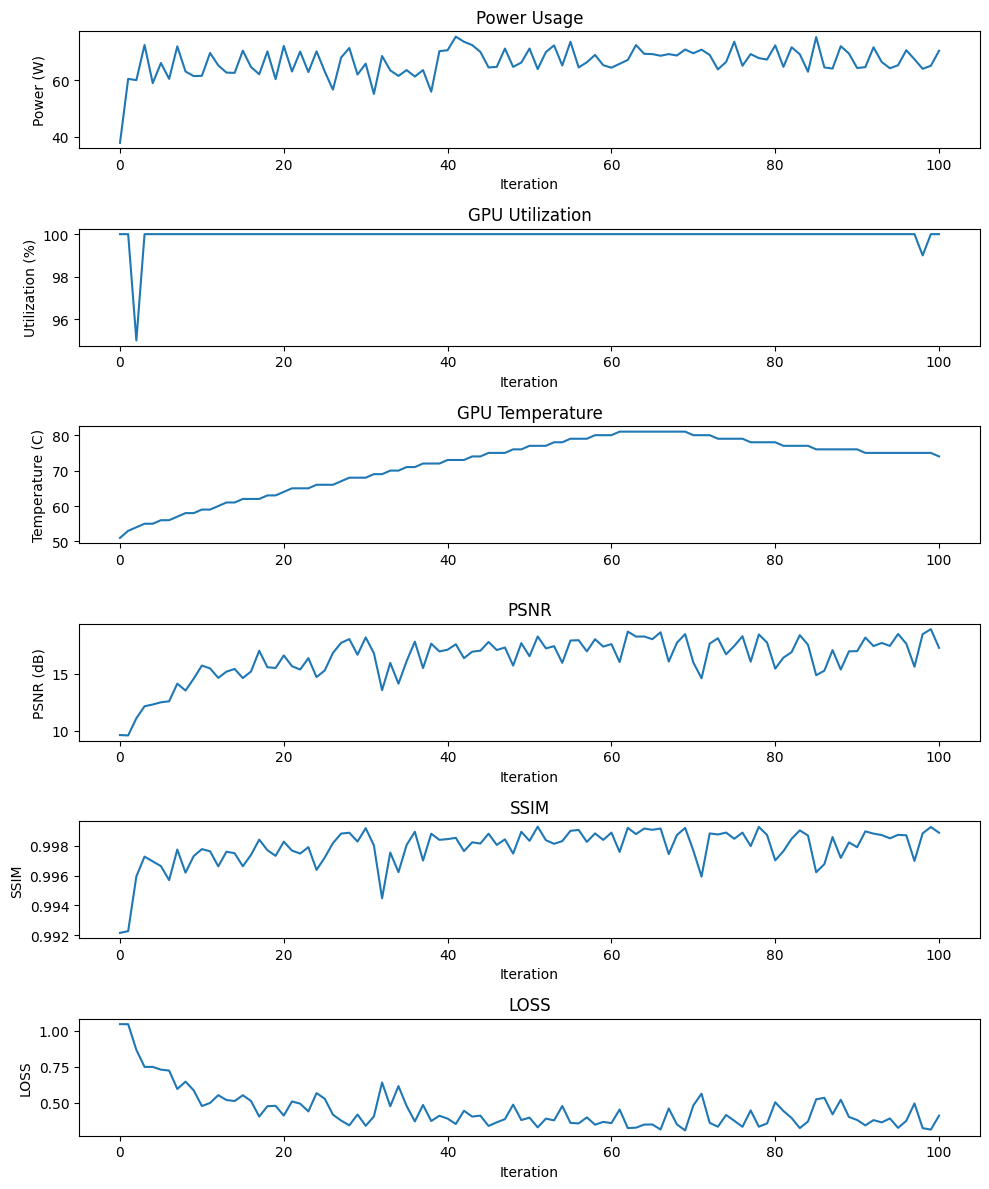

In [ ]:
import matplotlib.pyplot  as plt
# create a figure with 4 subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 12))

# plot power usage
axs[0].plot(power_list)
axs[0].set_title('Power Usage')
axs[0].set_ylabel('Power (W)')
axs[0].set_xlabel('Iteration')

# plot GPU utilization
axs[1].plot(gpu_list)
axs[1].set_title('GPU Utilization')
axs[1].set_ylabel('Utilization (%)')
axs[1].set_xlabel('Iteration')

# plot temperature
axs[2].plot(temp_list)
axs[2].set_title('GPU Temperature')
axs[2].set_ylabel('Temperature (C)')

# plot PSNR
axs[3].plot(psnr_list)
axs[3].set_title('PSNR')
axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('PSNR (dB)')

# plot SSIM
axs[4].plot(ssim_list)
axs[4].set_title('SSIM')
axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('SSIM')


#plot loss 
axs[5].plot(loss_list)
axs[5].set_title('LOSS')
axs[5].set_xlabel('Iteration')
axs[5].set_ylabel('LOSS')

# set the layout of the subplots
plt.tight_layout()

# display the plot
plt.show()

In [ ]:
# import pandas as pd

# df = pd.DataFrame({'power_usage': power_list, 'gpu_utilization': gpu_list, 'temperature': temp_list, 'psnr': psnr_list, 'ssim': ssim_list})

# print(df.head())

In [ ]:
import pickle


# Save the lists to a file
with open('A100_lists.pkl', 'wb') as f:
    pickle.dump([power_list, gpu_list, temp_list, psnr_list,ssim_list,times,roofline,loss_list], f)

In [ ]:
! nvidia-smi

Sun May 14 04:11:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   9455MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# with open('/content/blah/lists.pkl','rb') as f:
#   lists=pickle.load(f)
# print(lists)